## Práctica Guiada - Bagging (diabates)

En esta práctica vamos a utilizar el dataset de diabetes que se encuentra precargado en la biblioteca sklearn.

El dataset consiste en 10 variables fisiológicas: edad, sexo, peso, presión sanguínea y otras medidas en 442 pacientes y la variable target es un indicador del progreso de la enfermedad.<br>
En sklearn todas las variables se encuentran estandarizadas, es decir, centradas a media cero y con norma l2. <br>
Para más información puede consultar el paper original <a href="http://web.stanford.edu/~hastie/Papers/LARS/LeastAngle_2002.pdf">aquí</a>


## 1 - BaggingClassifier

La clase BaggingClassifier de sklearn permite crear un ensamble a partir de un clasificador base. 
El método se basa en entrenar al clasificador mediante distintas muestras del dataset generadas mediante bootstrap y promediar los resultados para reducir la varianza del estimador.

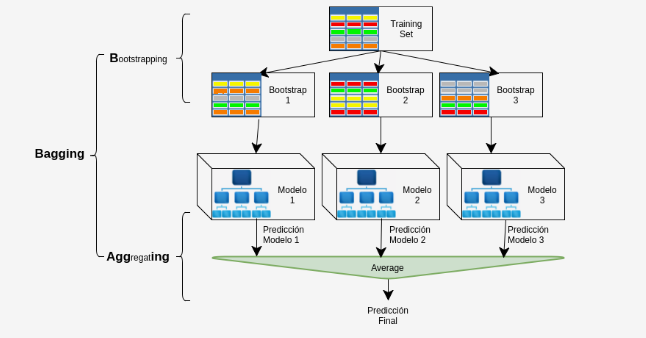

El método mejora significativamente la performance cuando la varianza del estimador de base era alta.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import cross_val_score

data = load_diabetes()
X = data['data']
y = data['target']

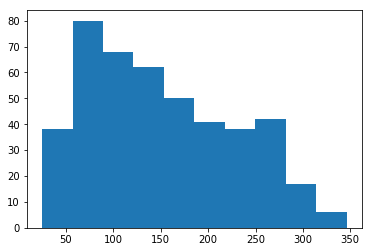

In [2]:
#Veamos la distribución de la clase
plt.hist(y);

## Ensamble vs Clasificador Base

A continuación generamos una función que devuelve el score de cross validation de cada estimador.

In [3]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.model_selection import KFold

def do_cross_val(model):
    my_fold = KFold(n_splits=5, shuffle=True, random_state=1)
    scores = cross_val_score(model, X, y, cv=my_fold, n_jobs=-1, scoring='r2')
    return scores.mean(), scores.std()


Vamos a generar dos clasificadores para evaluar: dtr, que contiene el clasificador base y bdtr que contiene el ensamble y evaluamos la media y el desvío de ambos.


In [4]:
dtr = DecisionTreeRegressor(max_depth=2)
do_cross_val(dtr)

(0.30719832148490617, 0.13490407865512796)

In [5]:
bdtr = BaggingRegressor(DecisionTreeRegressor())
do_cross_val(bdtr)

(0.32280511772570453, 0.16827597290212479)

### Cambiando el número de estimadores

Ahora veamos qué pasa si vamos modificando la cantidad de estimadores que incluímos en el ensamble y la complejidad del modelo. La complejidad del modelo ser regula con el parámetro max_depth que indica la profundidad del árbol. 

In [6]:
# Definimos esta función para calcular ensambles de distinto tamaño sobre el estimador que recibe. 

def calcular_scoring_stddev_bagging(basereg):
    scores=[]
    stddevs=[]
    for numreg in range(1,50):
        bdtr = BaggingRegressor(basereg,n_estimators=numreg)
        score,stddev=do_cross_val(bdtr)
        scores.append(score)
        stddevs.append(stddev)
        print (". "),
    return np.array(scores),np.array(stddevs)


In [7]:
# Armamos los scores para un estimador de profundidad 1
scores_bagging_shallow,stddev_bagging_shallow=calcular_scoring_stddev_bagging(DecisionTreeRegressor(max_depth=1))

. 
. 
. 
. 
. 
. 
. 
. 
. 
. 
. 
. 
. 
. 
. 
. 
. 
. 
. 
. 
. 
. 
. 
. 
. 
. 
. 
. 
. 
. 
. 
. 
. 
. 
. 
. 
. 
. 
. 
. 
. 
. 
. 
. 
. 
. 
. 
. 
. 


In [8]:
# Con el parámetro max_depth = None, el árbol se expande hasta lograr una clasificación perfecta 
# sobre los datos de entrenamiento.
scores_bagging_deep,stddev_bagging_deep=calcular_scoring_stddev_bagging(DecisionTreeRegressor(max_depth=None))

. 
. 
. 
. 
. 
. 
. 
. 
. 
. 
. 
. 
. 
. 
. 
. 
. 
. 
. 
. 
. 
. 
. 
. 
. 
. 
. 
. 
. 
. 
. 
. 
. 
. 
. 
. 
. 
. 
. 
. 
. 
. 
. 
. 
. 
. 
. 
. 
. 


## Comparación de modelos

Tenemos, entonces, los scores de ensambles construidos con una cantidad de estimadores que varía desde 1 a 50 para tres modelos de distinta complejidad. 

Vamos a graficar la media y el desvío de la performance de cada modelo medida en términos de "r2"

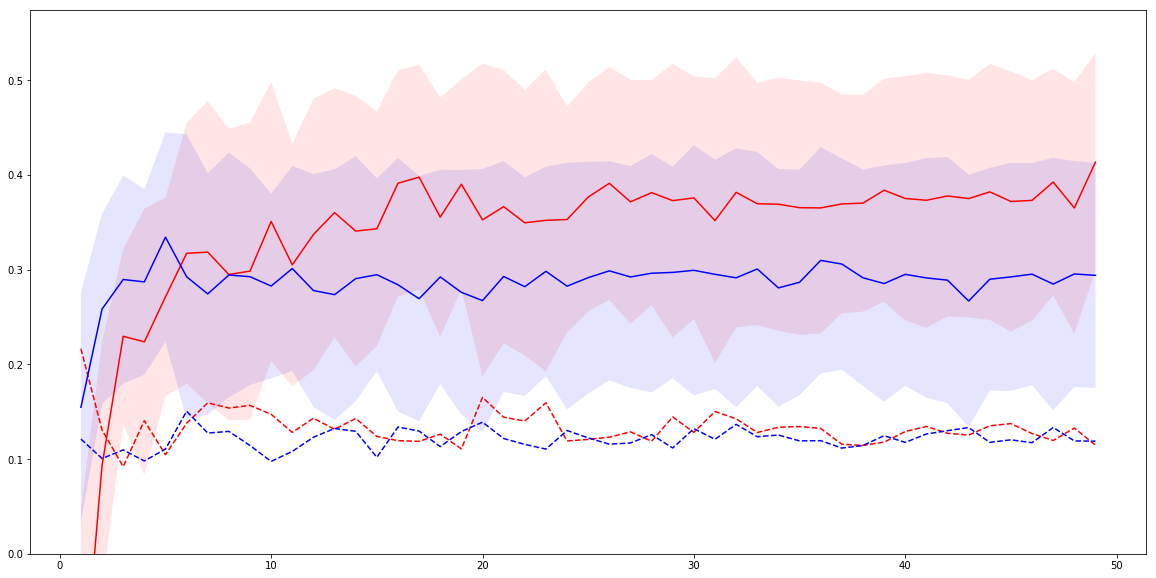

In [9]:
def graficar_curva(scores,stddev,color):
    x_axis=range(1,len(scores)+1)

    plt.plot(x_axis,scores,color)
    plt.plot(x_axis,stddev, color+"--")
    plt.fill_between(x_axis,scores + stddev, scores - stddev, alpha=0.1, facecolor=color)

    
plt.figure().set_size_inches(20, 10)
graficar_curva(scores_bagging_deep,stddev_bagging_deep,"r")
graficar_curva(scores_bagging_shallow,stddev_bagging_shallow,"b")
plt.ylim(0)
plt.show()


#### Interpretación del gráfico:

El modelo "simple" (azul) performa mejor que el rojo cuando hay un sólo clasificador. Este modelo tiene mucho sesgo por ser extremadamente sencillo.

El modelo "complejo" (rojo) "aprende" perfectamente los datos de entrenamiento pero tiene problemas para generalizar en datos de validación. Por eso un único clasificador tiene muy mala performance. Es un modelo con alta varianza.  

A medida que aumentamos la cantidad de clasificadores en el ensamble, el modelo rojo reduce la varianza de la predicción y alcanza resultados mejores que el modelo azul.

## Uno de los estimadores base, max_depth = 2


Para poder correr estas visualiaciones, abrir una terminal y ejecutar:

pip install pydotplus <br />
conda install graphviz


In [10]:
from IPython.display import Image
from sklearn.tree import export_graphviz
import pydotplus

bdtr = BaggingRegressor(DecisionTreeRegressor(max_depth=2),n_estimators=50)
bdtr.fit(X,y)

BaggingRegressor(base_estimator=DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=50, n_jobs=1, oob_score=False,
         random_state=None, verbose=0, warm_start=False)

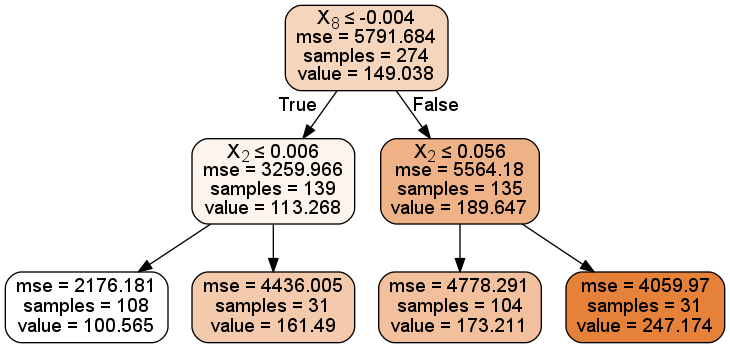

In [11]:
dot_data=export_graphviz(bdtr.estimators_[0], out_file=None,  
                
                filled=True, rounded=True,  
                special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

Ahora observemos el siguiente árbol del ensamble ¿Es similar? ¿Es muy diferente?

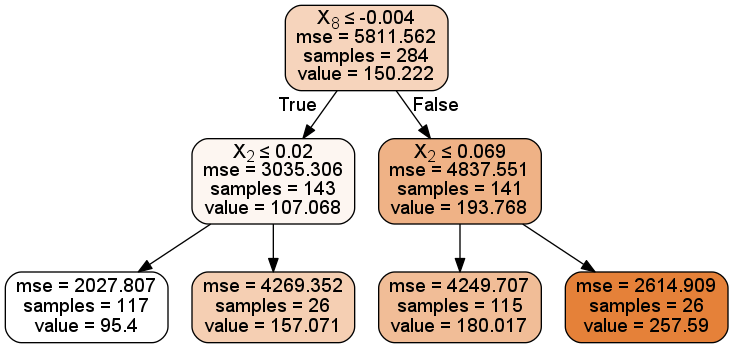

In [12]:

dot_data=export_graphviz(bdtr.estimators_[1], out_file=None,  
                
                filled=True, rounded=True,  
                special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

## Uno de los estimadores base, max_depth = 5

Observen cuánto crece la cantidad de parámetros estimada por el modelo cuando pasamos de una profundidad de 2 a una de 5.

In [13]:
# Aqui mostramos uno de los estimadores que forman parte del ensamble

from IPython.display import Image
from sklearn.tree import export_graphviz
import pydotplus

bdtr = BaggingRegressor(DecisionTreeRegressor(max_depth=5),n_estimators=50)
bdtr.fit(X,y)

BaggingRegressor(base_estimator=DecisionTreeRegressor(criterion='mse', max_depth=5, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=50, n_jobs=1, oob_score=False,
         random_state=None, verbose=0, warm_start=False)

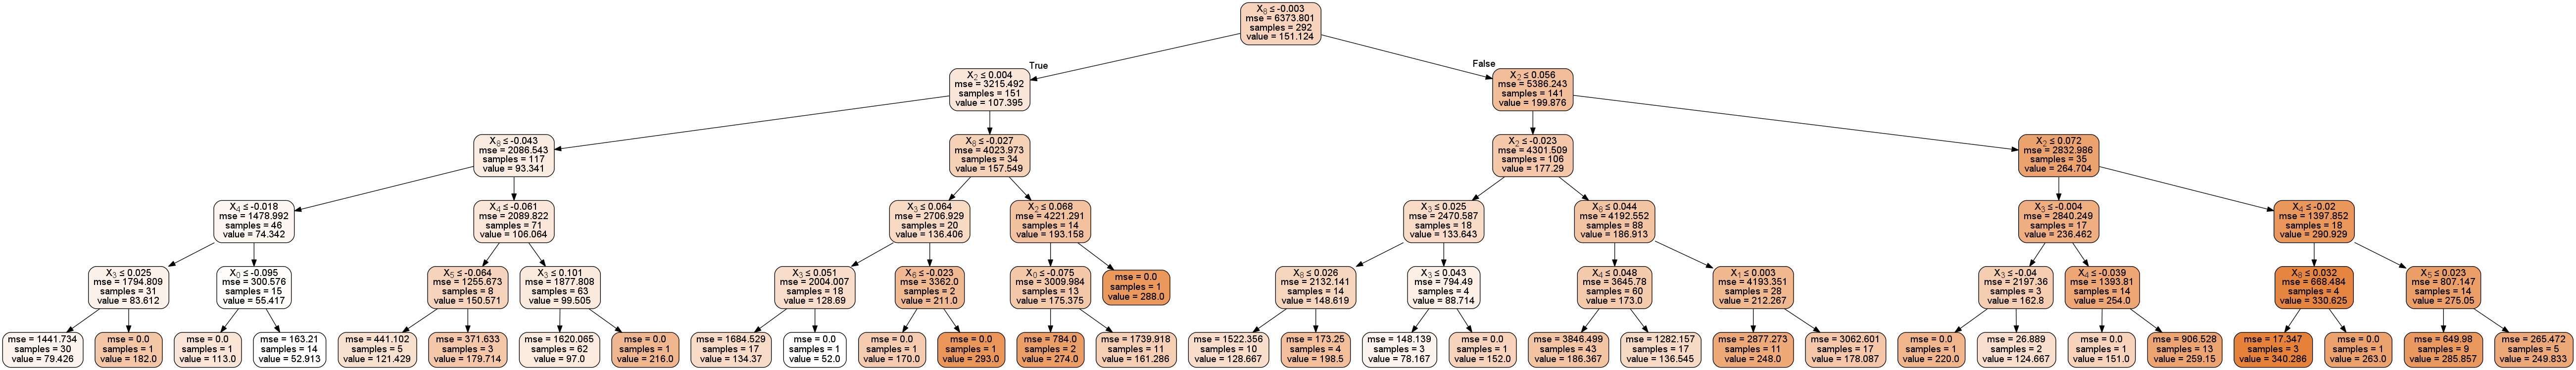

In [14]:
dot_data=export_graphviz(bdtr.estimators_[0], out_file=None,  
                
                filled=True, rounded=True,  
                special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())